In [190]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
#import imutils
#import easyocr
import os
#import pytesseract

<h3>Reading images</h3>

In [191]:
#reader = easyocr.Reader(['en'])
#folder_path = "D:/M1 S2/ML/LPR Project/Numb_plate_imgs"

def readImg(img):
    folder_path="C:/Users/HP/Desktop/projet_ML/path/images/LPR Project/Numb_plate_imgs"
    file_name = img
    img_path = os.path.join(folder_path, file_name)
    im = cv2.imread(img_path)
    #print("La taille de l'image est :", np.shape(im))
    return im
#plt.imshow(cv2.cvtColor(readImg("Cars208.png"), cv2.COLOR_BGR2RGB))
#plt.show()

<h3>Converting images to grayscale + Maximizing contrast</h3>

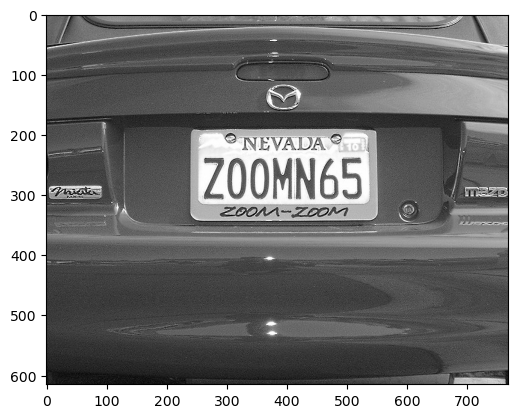

In [192]:
def convertGray(img):
    #im=cv2.imread(img)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #plt.imshow(cv2.cvtColor(gray,cv2.COLOR_BGR2RGB))
    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
    imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

    imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
    gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)
    return gray

im=readImg("10.png")
plt.imshow(cv2.cvtColor(convertGray(im), cv2.COLOR_BGR2RGB))

<h2>Applying the adaptive tresholding filter to the image</h2>

In [193]:
def adaptiveThresholding(img, blockSize=15, C=4):

    # help reducing the high-frequency noise present in an image
    img_blurred = cv2.GaussianBlur(convertGray(img), ksize=(5, 5), sigmaX=0)
    # Appliquer le filtre de seuillage adaptatif
    edged = cv2.adaptiveThreshold(img_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize, C)
    
    # Afficher l'image seuillée
    #plt.imshow(edged, cmap='gray')
    #plt.axis('off')
    plt.show()
    return edged

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255,   0, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

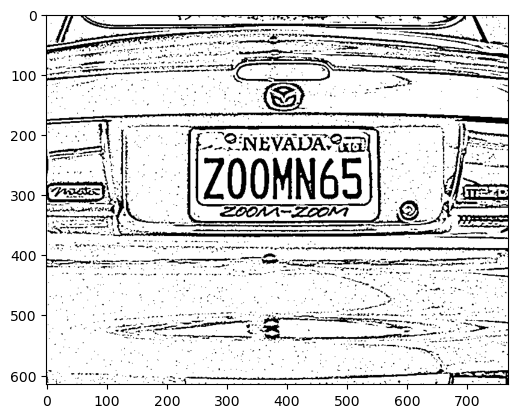

In [194]:


edg=adaptiveThresholding(im)
#edg=BilatFilt(im)
plt.imshow(cv2.cvtColor(edg,cv2.COLOR_BGR2RGB))
edg

<h3>Find Contours</h3>

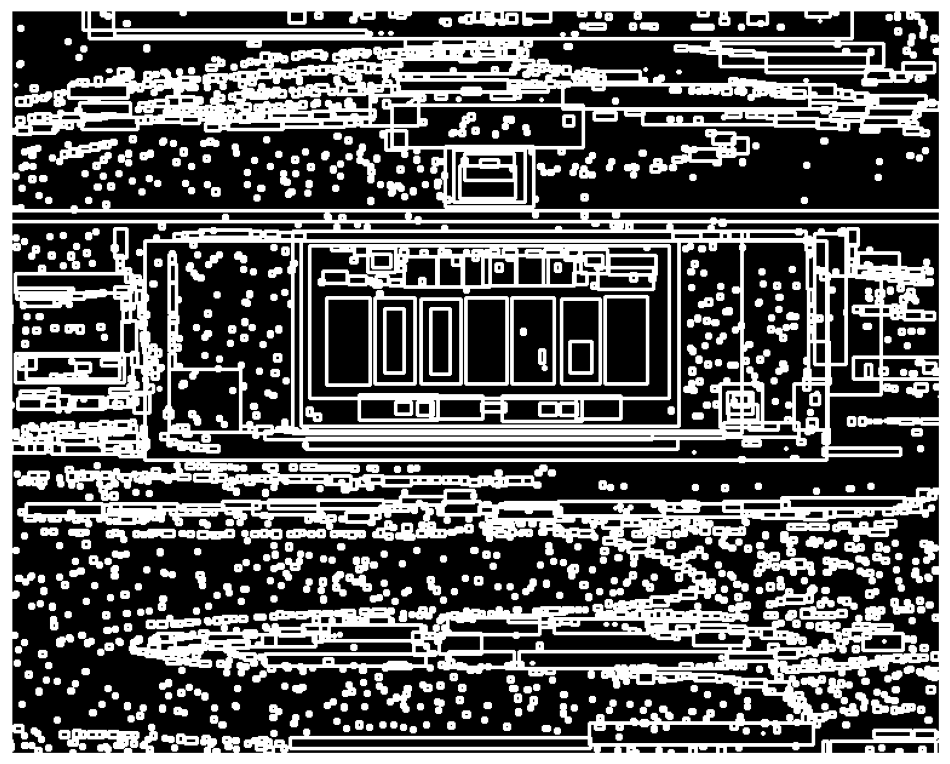

In [195]:
height, width, channel = im.shape
contours, _= cv2.findContours(
    edg, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)
plt.axis('off')
#plt.savefig('Car-Boxes.png',bbox_inches = 'tight')
plt.show()

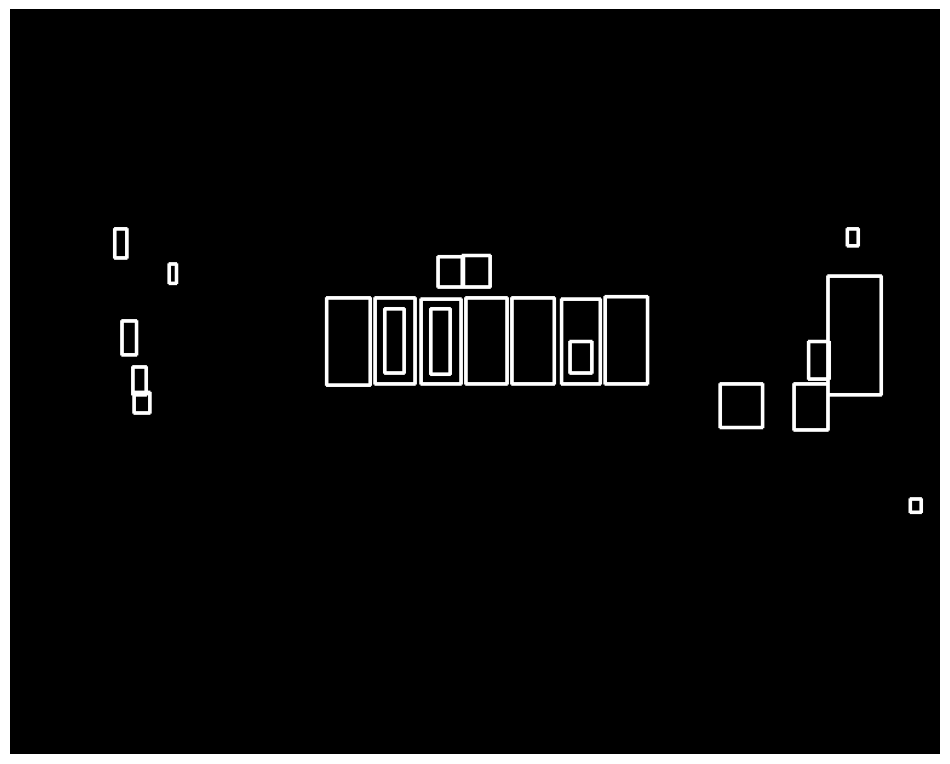

In [196]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))

 cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
#plt.savefig('Car-Boxes-byCharSize.png',bbox_inches = 'tight')
plt.show()


<h2>Final Filtering process</h2>

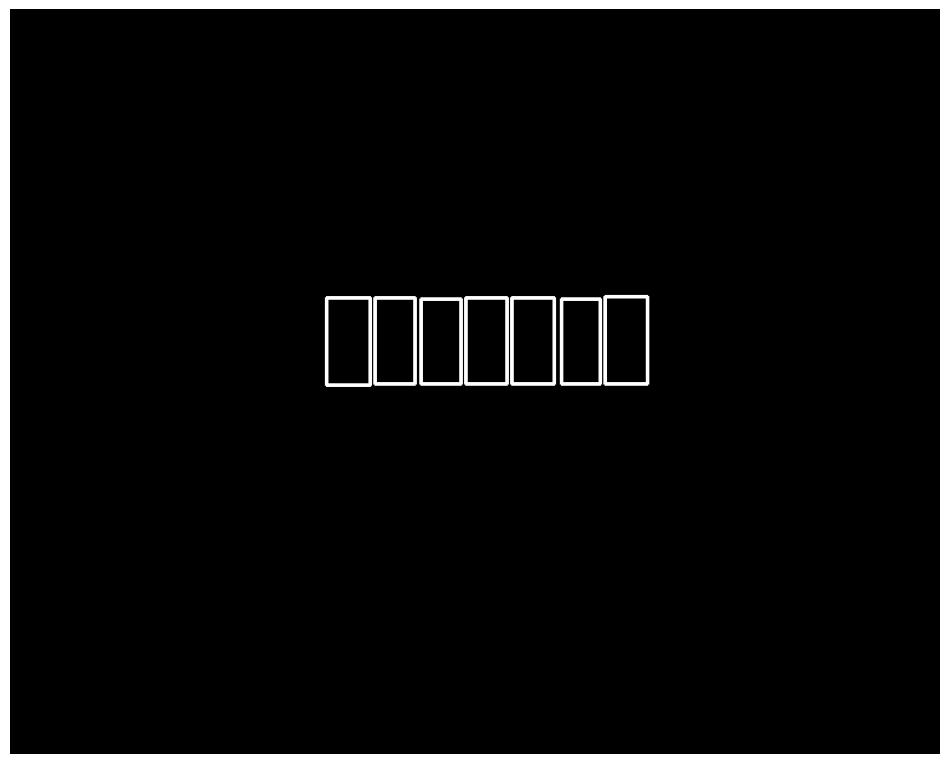

In [197]:
MAX_DIAG_MULTIPLYER = 5 # 5
MAX_ANGLE_DIFF = 12.0 # 12.0
MAX_AREA_DIFF = 0.5 # 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3 # 3

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue
        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)
plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
#plt.savefig('Car-Boxes-byContourArrangement.png',bbox_inches = 'tight')
plt.show()

<h3>Show the contours within the original image</h3>

In [198]:
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

# Find the largest boxes
largest_boxes = []
for r in matched_result:
    largest_box = max(r, key=lambda x: x['w'] * x['h'])
    largest_boxes.append(largest_box)

# Draw only the largest boxes
for d in largest_boxes:
    cv2.rectangle(im, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)

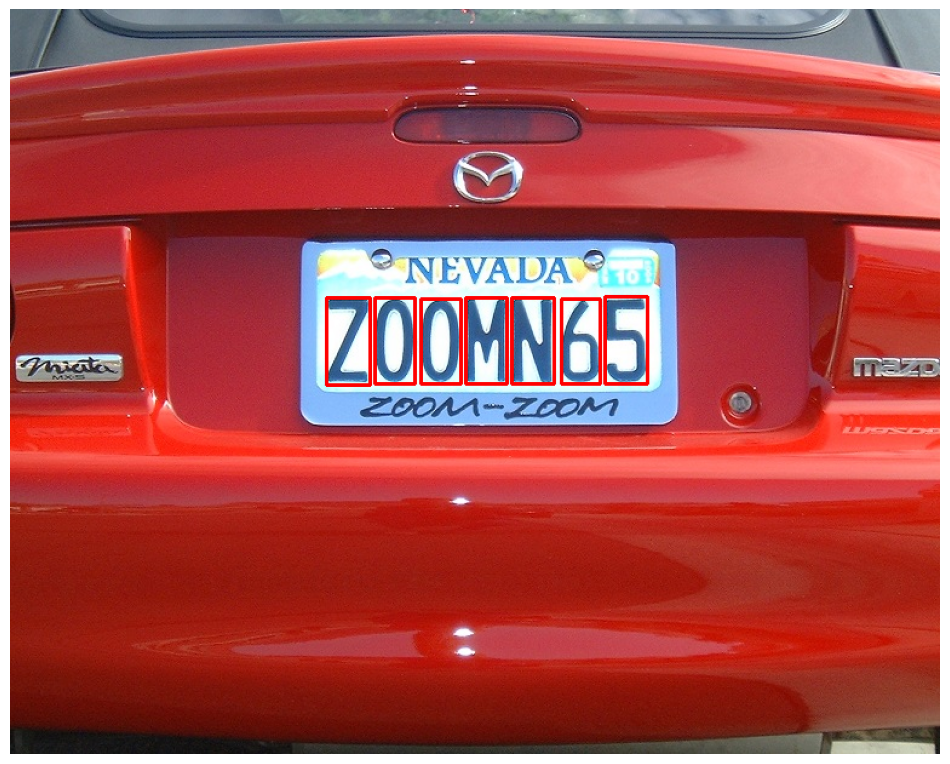

In [199]:
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(im, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)





# Sort the largest boxes based on their x-coordinate
largest_boxes.sort(key=lambda x: x['x'])

# Find adjacent boxes
adjacent_boxes = []
for i in range(len(largest_boxes) - 1):
    current_box = largest_boxes[i]
    next_box = largest_boxes[i+1]
    if next_box['x'] == current_box['x'] + current_box['w']:
        adjacent_boxes.append(current_box)
        adjacent_boxes.append(next_box)

# Draw only the adjacent boxes
for d in adjacent_boxes:
    cv2.rectangle(im, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.axis('off')
#plt.savefig('Car-BigBoxes.png', bbox_inches='tight')
plt.show()


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


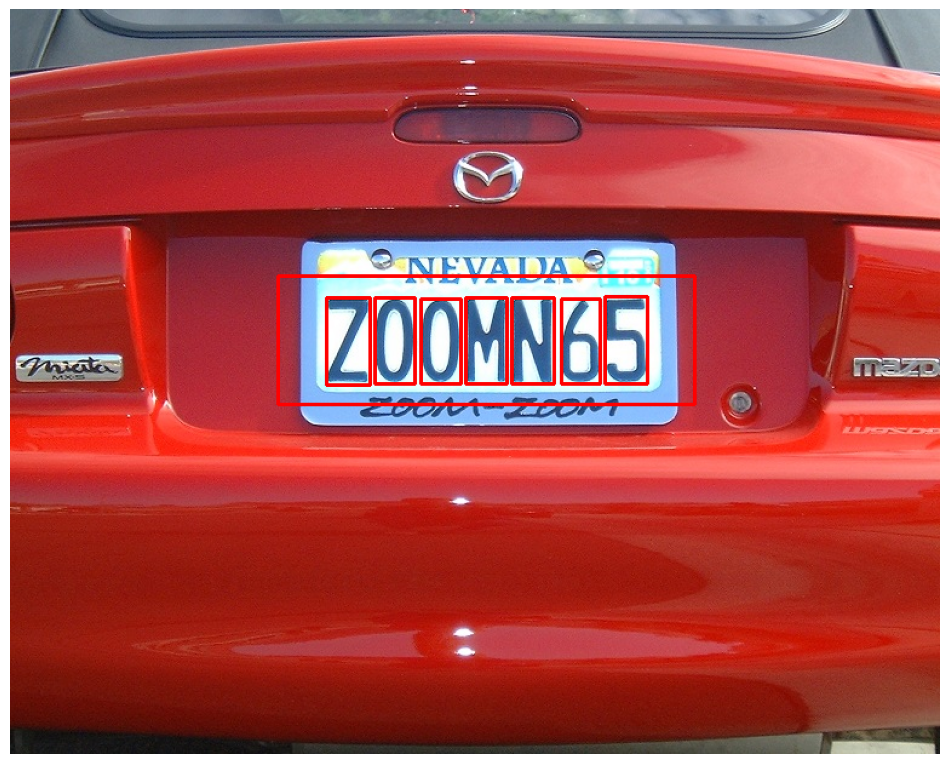

In [200]:
import cv2
import numpy as np
import easyocr
from PIL import Image
import matplotlib.pyplot as plt

MIN_PLATE_WIDTH, MIN_PLATE_HEIGHT = 100, 80
PLATE_WIDTH_PADDING = 1.3
PLATE_HEIGHT_PADDING = 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []
adjacent_boxes = []

reader = easyocr.Reader(['en'])


# Your code to obtain 'matched_result'


for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2

    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)

    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenuse = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) -
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenuse))

    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)

    img_rotated = cv2.warpAffine(im, M=rotation_matrix, dsize=(im.shape[1], im.shape[0]))

    img_cropped = cv2.getRectSubPix(
        img_rotated,
        patchSize=(int(plate_width), int(plate_height)),
        center=(int(plate_cx), int(plate_cy))
    )
    plate_ratio = img_cropped.shape[1] / img_cropped.shape[0]
    if plate_ratio < MIN_PLATE_RATIO or plate_ratio > MAX_PLATE_RATIO:
        continue

    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue

    if adjacent_boxes:
        previous_box = adjacent_boxes[-1]
        current_box = {
            'x': int(plate_cx - plate_width / 2),
            'y': int(plate_cy - plate_height / 2),
            'w': int(plate_width),
            'h': int(plate_height)
        }
        if previous_box['x'] + previous_box['w'] == current_box['x']:
            adjacent_boxes.append(current_box)
        else:
            if len(adjacent_boxes) >= 2:
                for d in adjacent_boxes:
                    cv2.rectangle(im, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)
            adjacent_boxes = [current_box]
    else:
        adjacent_boxes.append({
            'x': int(plate_cx - plate_width / 2),
            'y': int(plate_cy - plate_height / 2),
            'w': int(plate_width),
            'h': int(plate_height)
        })

# Draw the last adjacent boxes
if len(adjacent_boxes) >= 2:
    for d in adjacent_boxes:
        cv2.rectangle(im, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)

# Perform OCR on the license plate images
for d in adjacent_boxes:
    x, y, w, h = d['x'], d['y'], d['w'], d['h']
    plate_img = im[y:y+h, x:x+w]

    # Perform OCR on the plate image
    result = reader.readtext(plate_img)
    if len(result) > 0:
        plate_text = result[0][1]  # Get the recognized text
        plate_confidence = result[0][2]  # Get the confidence score
    else:
        plate_text = ""
        plate_confidence = 0.0

    # Add the plate image, recognized text, and confidence to lists
    plate_imgs.append(plate_img)
    plate_infos.append({'x': x, 'y': y, 'w': w, 'h': h, 'text': plate_text, 'confidence': plate_confidence})

    """
    # Display result and accuracy in the console
    print(f"Plate Text: {plate_text}")
    print(f"Accuracy: {plate_confidence:.2f}")
    print("-----------------------------------")"""

    # Display result on the original image
    cv2.rectangle(im, pt1=(x, y), pt2=(x+w, y+h), color=(0, 0, 255), thickness=2)
    #cv2.putText(im, f"{plate_text} ({plate_confidence:.2f})", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)


plt.figure(figsize=(12, 10))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()








<h2>Display all the selected plates and show them in order(the plates that contains charachters first) </h2>

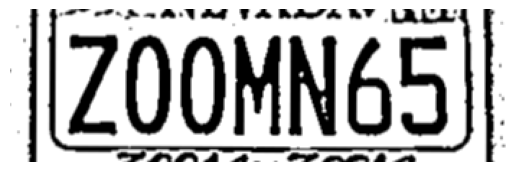

In [201]:
plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenuse = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenuse))
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    img_rotated = cv2.warpAffine(edg, M=rotation_matrix, dsize=(width, height))
    
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] > MAX_PLATE_RATIO:
        continue
    
    # Perform character recognition on the plate image
    result = reader.readtext(img_cropped)

    # Check if there are any recognized characters
    if len(result) == 0:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })

# Sort the plates in descending order based on their length
plate_imgs = sorted(plate_imgs, key=lambda img: img.shape[1], reverse=True)
plate_infos = sorted(plate_infos, key=lambda info: info['w'], reverse=True)

# Display the sorted plates
for i, (plate_img, plate_info) in enumerate(zip(plate_imgs, plate_infos)):
    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(plate_img, cmap='gray')
    plt.axis('off')
    plt.show()


<h2>use all this code in one function</h2>

<h2> Display only the first license plate found</h2>

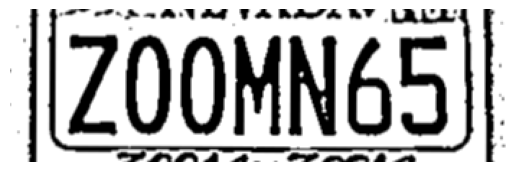

In [202]:
plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenuse = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenuse))
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    img_rotated = cv2.warpAffine(edg, M=rotation_matrix, dsize=(width, height))
    
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] > MAX_PLATE_RATIO:
        continue
    
    # Perform character recognition on the plate image
    result = reader.readtext(img_cropped)

    # Check if there are any recognized characters
    if len(result) == 0:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })

# Sort the plates in descending order based on their length
plate_imgs = sorted(plate_imgs, key=lambda img: img.shape[1], reverse=True)
plate_infos = sorted(plate_infos, key=lambda info: info['w'], reverse=True)

# Display the first extracted plate
if len(plate_imgs) > 0:
    plt.imshow(plate_imgs[0], cmap='gray')
    plt.axis('off')
    plt.show()

else:
    plt.imshow(img_cropped, cmap='gray')
    plt.axis('off')
    plt.show()

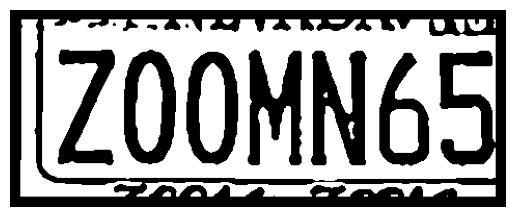

In [203]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')
    plt.axis('off')
    #plt.savefig('Car-Plates(Thresholding).png',bbox_inches = 'tight')
    plt.show()
    break

Prediction: ZOOMN65
Accuracy: 0.98
-----------------------------------


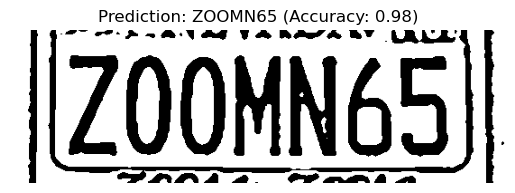

In [204]:
if len(plate_imgs) > 0:
    plate_img = plate_imgs[0]
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Perform character recognition on the plate image
    result = reader.readtext(plate_img)

    # Extract the recognized characters and their confidence
    characters = [char_result[1] for char_result in result]
    confidences = [char_result[2] for char_result in result]

    # Find the index of the character with the highest confidence
    if len(confidences) > 0 and len(characters) > 0:
        max_confidence_idx = np.argmax(confidences)
        # Check if max_confidence_idx is within the valid range
        if 0 <= max_confidence_idx < len(characters):
            # Get the character and confidence with the highest accuracy
            max_character = characters[max_confidence_idx]
            max_confidence = confidences[max_confidence_idx]
        else:
            # Handle the case when max_confidence_idx is out of range
            max_character = ""
            max_confidence = 0.0
    else:
        # Handle the case when confidences or characters is empty
        max_character = ""
        max_confidence = 0.0

    # Print the recognized character and its confidence
    print(f"Prediction: {max_character}")
    print(f"Accuracy: {max_confidence:.2f}")
    print("-----------------------------------")

    # Display the recognized character and its confidence on the original image
    plate_info = plate_infos[0]
    x, y, w, h = plate_info['x'], plate_info['y'], plate_info['w'], plate_info['h']
    cv2.putText(im, f"{max_character} ({max_confidence:.2f})", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # Visualize the recognized character on the plate image
    plt.imshow(plate_img, cmap='gray')
    plt.axis('off')
    plt.title(f"Prediction: {max_character} (Accuracy: {max_confidence:.2f})")
    plt.show()


<h2>Showing the result in the originale image </h2>

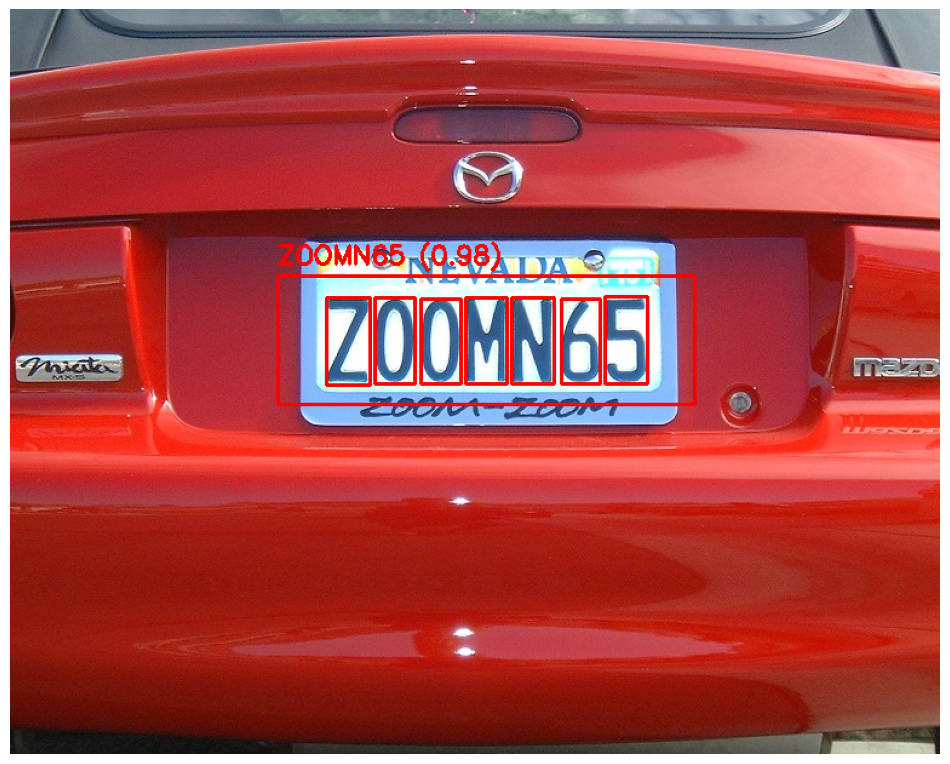

In [205]:
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(im, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)





# Sort the largest boxes based on their x-coordinate
largest_boxes.sort(key=lambda x: x['x'])

# Find adjacent boxes
adjacent_boxes = []
for i in range(len(largest_boxes) - 1):
    current_box = largest_boxes[i]
    next_box = largest_boxes[i+1]
    if next_box['x'] == current_box['x'] + current_box['w']:
        adjacent_boxes.append(current_box)
        adjacent_boxes.append(next_box)

# Draw only the adjacent boxes
for d in adjacent_boxes:
    cv2.rectangle(im, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.axis('off')
#plt.savefig('Car-BigBoxes.png', bbox_inches='tight')
plt.show()


<h2>Using machine learning models</h2>

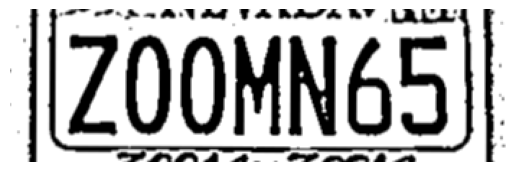

In [206]:
plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenuse = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenuse))
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    img_rotated = cv2.warpAffine(edg, M=rotation_matrix, dsize=(width, height))
    
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] > MAX_PLATE_RATIO:
        continue
    
    # Perform character recognition on the plate image
    result = reader.readtext(img_cropped)

    # Check if there are any recognized characters
    if len(result) == 0:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })

# Sort the plates in descending order based on their length
plate_imgs = sorted(plate_imgs, key=lambda img: img.shape[1], reverse=True)
plate_infos = sorted(plate_infos, key=lambda info: info['w'], reverse=True)

# Display the first extracted plate
if len(plate_imgs) > 0:
    plt.imshow(plate_imgs[0], cmap='gray')
    plt.axis('off')
    plt.show()

else:
    plt.imshow(img_cropped, cmap='gray')
    plt.axis('off')
    plt.show()

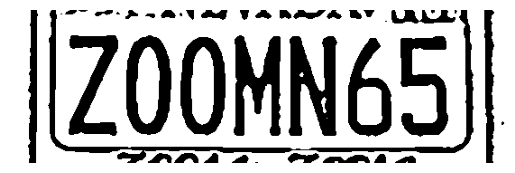

In [207]:
import numpy as np

plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    
    # Find contours of individual characters
    char_contours, _ = cv2.findContours(img_result, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

    for char_contour in char_contours:
        x, y, w, h = cv2.boundingRect(char_contour)
        char_img = img_result[y:y+h, x:x+w]
        plate_chars.append(char_img)
        
        # Draw bounding boxes on the original plate image
        
    
    # Display the original plate image with bounding boxes
    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.axis('off')
    plt.show()
  


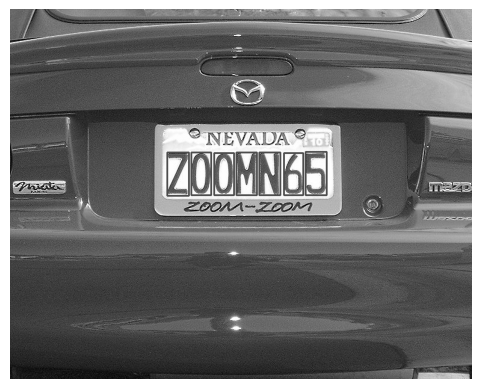

In [208]:
im = readImg("10.png")

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(im, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)
        

# Sort the largest boxes based on their x-coordinate
largest_boxes.sort(key=lambda x: x['x'])
"""
# Find adjacent boxes
adjacent_boxes = []
for i in range(len(largest_boxes) - 1):
    current_box = largest_boxes[i]
    next_box = largest_boxes[i+1]
    if next_box['x'] == current_box['x'] + current_box['w']:
        adjacent_boxes.append(current_box)
        adjacent_boxes.append(next_box)"""


"""# Draw only the adjacent boxes
for d in adjacent_boxes:
    cv2.rectangle(im, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)"""

#plt.figure(figsize=(12, 10))
#plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.imshow(cv2.cvtColor(convertGray(im), cv2.COLOR_BGR2RGB))

plt.axis('off')
#plt.savefig('Car-BigBoxes.png', bbox_inches='tight')
plt.show()

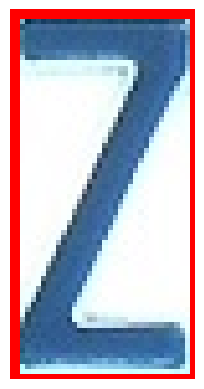

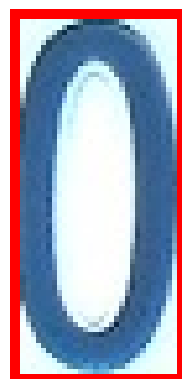

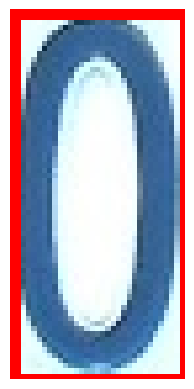

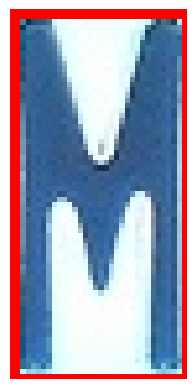

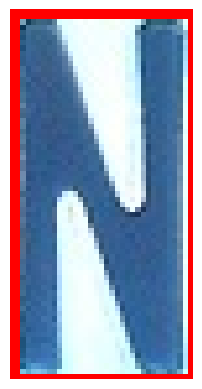

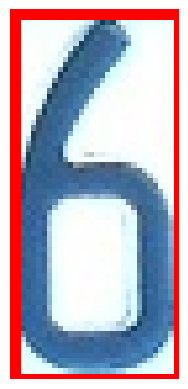

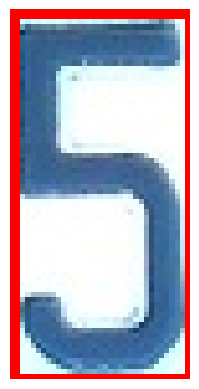

In [209]:
# Sort the matched boxes based on their x-coordinate
sorted_result = []
for r in matched_result:
    sorted_result.extend(sorted(r, key=lambda x: x['x']))

# Display the character images in left-to-right order
for i, d in enumerate(sorted_result):
    x, y, w, h = d['x'], d['y'], d['w'], d['h']
    char_img = im[y:y+h, x:x+w]

    # Calculate the left-to-right order index
    #order_index = i + 1

    # Display the character image
    plt.imshow(cv2.cvtColor(char_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    #plt.title(f'Order: {order_index}')
    plt.show()


In [210]:
from skimage.feature import hog

<h1>let try to pridect using maching learning model</h1>

In [211]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def preprocess(image):
    # Resize the image to 28x28
    img = cv2.resize(image, (70, 70))

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Compute the HOG features
    hog_features, hog_image = hog(gray_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

    return hog_features

# ... (previous code for preprocessing and contour detection)


In [212]:
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load the CSV data
csv_filename = 'features667_size3_c.csv'
data = []
labels = []

with open(csv_filename, mode='r') as file:
    reader = csv.reader(file)
    header_row = next(reader)  # Skip the header row

    for row in reader:
        features = np.array(row[:-1], dtype=np.float32)  # Convert features to numpy array
        label = row[-1]
        data.append(features)
        labels.append(label)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Train the SVM classifier
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Predict some images from your path
#path = 'your_image_path'  # Replace with the actual path to your images

# Load and preprocess the images
# ...

# Extract features from the preprocessed images
# ...

# Make predictions using the trained SVM classifier
#predictions = svm.predict(features)

# Print the predicted labels
#print("Predictions:")
#for image_path, label in zip(image_paths, predictions):
 #   print(f"{image_path}: {label}")


Accuracy: 0.9863713798977853


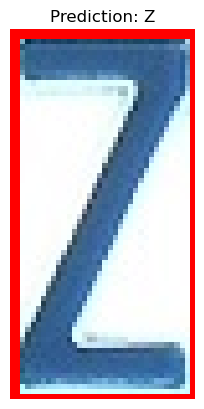

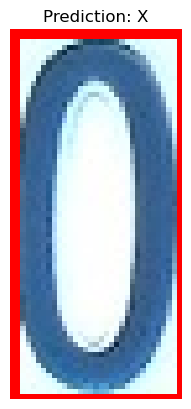

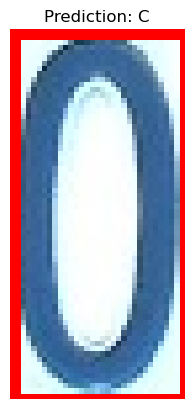

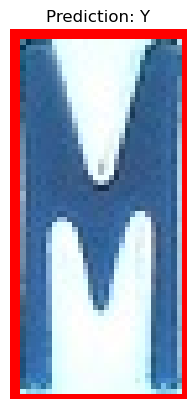

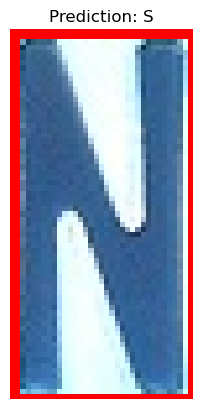

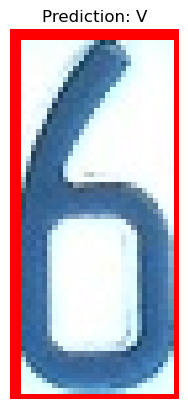

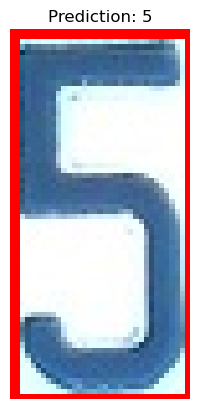

In [213]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess(image):
    # Resize the image to 28x28
    img = cv2.resize(image, (70, 70))

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Compute the HOG features
    hog_features, hog_image = hog(gray_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

    return hog_features

# Sort the matched boxes based on their x-coordinate
sorted_result = []
for r in matched_result:
    sorted_result.extend(sorted(r, key=lambda x: x['x']))

# Display the character images in left-to-right order
for i, d in enumerate(sorted_result):
    x, y, w, h = d['x'], d['y'], d['w'], d['h']
    char_img = im[y:y+h, x:x+w]

    # Preprocess the character image
    preprocessed_img = preprocess(char_img)

    # Make predictions using the trained SVM classifier
    prediction = svm.predict([preprocessed_img])

    # Display the character image and its predicted label
    plt.imshow(cv2.cvtColor(char_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Prediction: {prediction[0]}')
    plt.show()

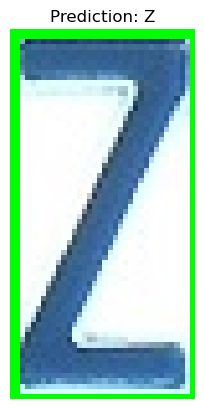

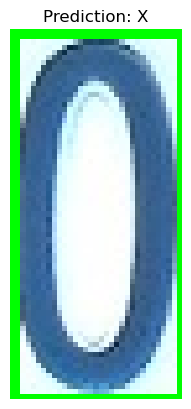

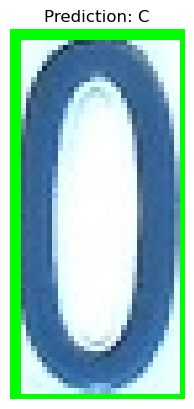

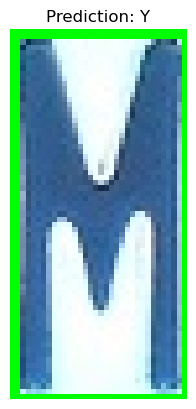

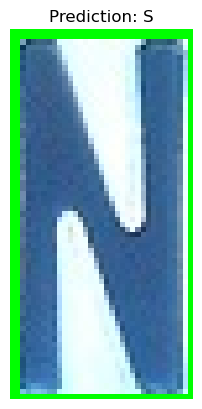

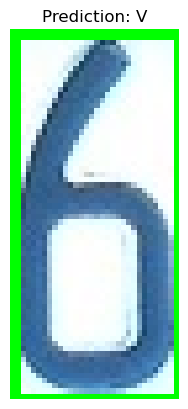

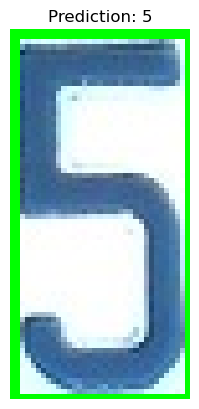

the pridected label is : ['Z', 'X', 'C', 'Y', 'S', 'V', '5']


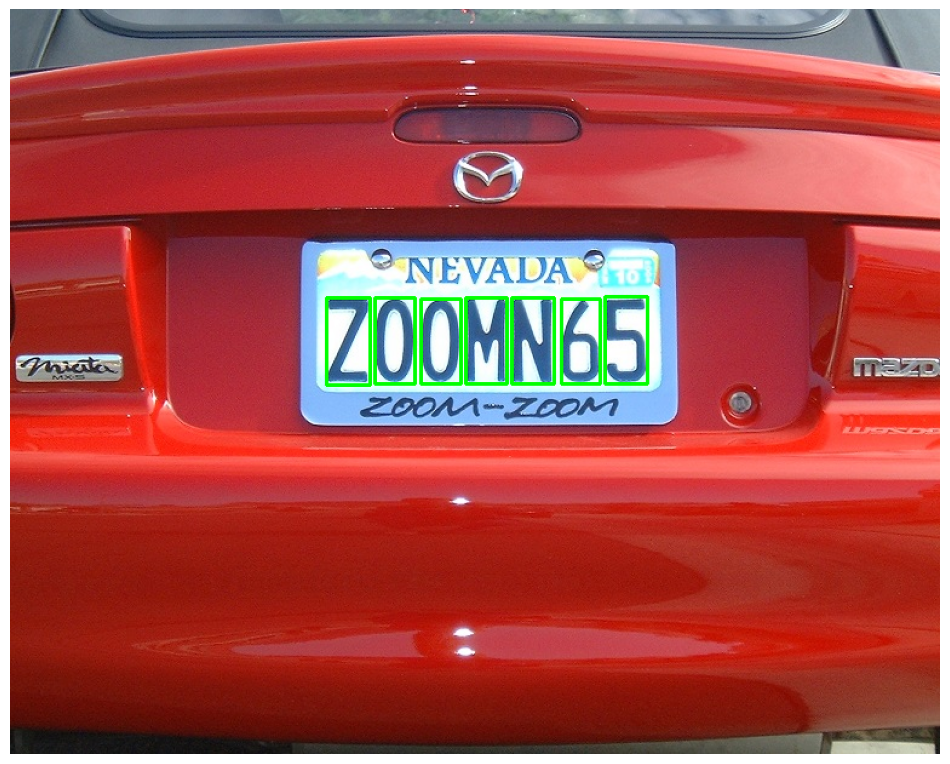

In [214]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess(image):
    # Resize the image to 28x28
    img = cv2.resize(image, (70, 70))

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Compute the HOG features
    hog_features, hog_image = hog(gray_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

    return hog_features

# Sort the largest boxes based on their x-coordinate
largest_boxes.sort(key=lambda x: x['x'])

# Find adjacent boxes
adjacent_boxes = []
for i in range(len(largest_boxes) - 1):
    current_box = largest_boxes[i]
    next_box = largest_boxes[i+1]
    if next_box['x'] == current_box['x'] + current_box['w']:
        adjacent_boxes.append(current_box)
        adjacent_boxes.append(next_box)

# Draw only the adjacent boxes
for d in adjacent_boxes:
    cv2.rectangle(im, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)

# Sort the matched boxes based on their x-coordinate
sorted_result = []
for r in matched_result:
    sorted_result.extend(sorted(r, key=lambda x: x['x']))
list_label=[]
# Display the character images in left-to-right order
for i, d in enumerate(sorted_result):
    x, y, w, h = d['x'], d['y'], d['w'], d['h']
    char_img = im[y:y+h, x:x+w]

    # Preprocess the character image
    preprocessed_img = preprocess(char_img)

    # Make predictions using the trained SVM classifier
    prediction = svm.predict([preprocessed_img])
    list_label.append(prediction[0])
    # Draw a rectangle around the character in the original image
    cv2.rectangle(im, pt1=(x, y), pt2=(x+w, y+h), color=(0, 255, 0), thickness=2)

    # Display the character image and its predicted label
    plt.imshow(cv2.cvtColor(char_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Prediction: {prediction[0]}')
    plt.show()
print("the pridected label is :",list_label)
plt.figure(figsize=(12, 10))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.axis('off')
#plt.savefig('Car-BigBoxes.png', bbox_inches='tight')
plt.show()


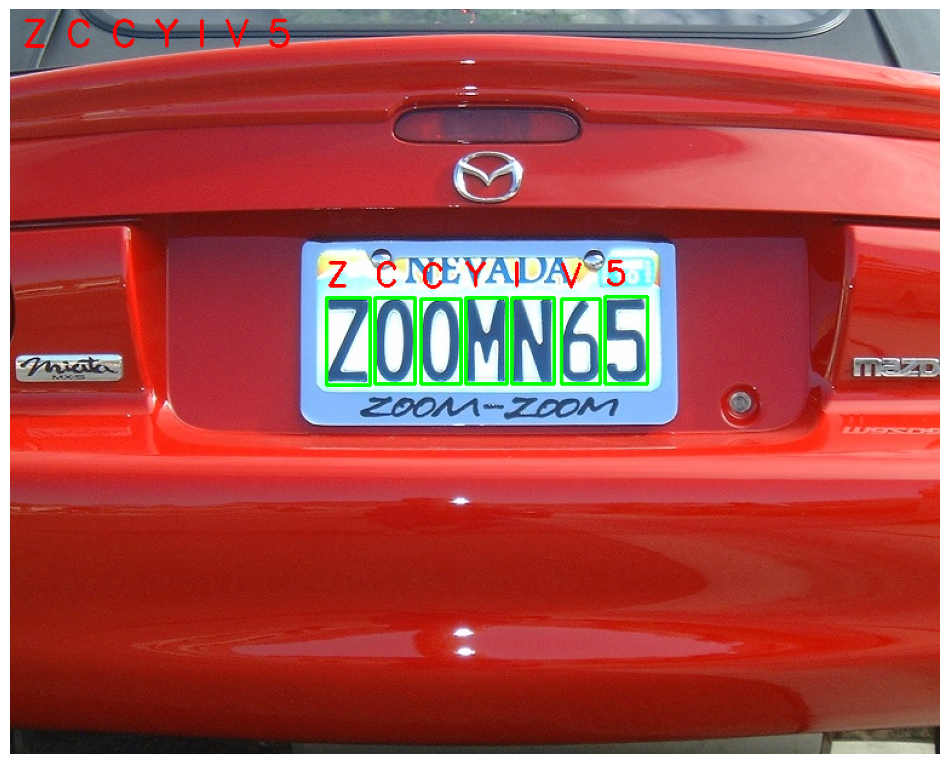

In [216]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess(image):
    # Resize the image to 28x28
    img = cv2.resize(image, (70, 70))

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Compute the HOG features
    hog_features, hog_image = hog(gray_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

    return hog_features

# Sort the largest boxes based on their x-coordinate
largest_boxes.sort(key=lambda x: x['x'])

# Find adjacent boxes
adjacent_boxes = []
for i in range(len(largest_boxes) - 1):
    current_box = largest_boxes[i]
    next_box = largest_boxes[i+1]
    if next_box['x'] == current_box['x'] + current_box['w']:
        adjacent_boxes.append(current_box)
        adjacent_boxes.append(next_box)

# Draw only the adjacent boxes
for d in adjacent_boxes:
    cv2.rectangle(im, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)

# Sort the matched boxes based on their x-coordinate
sorted_result = []
for r in matched_result:
    sorted_result.extend(sorted(r, key=lambda x: x['x']))
list_label=[]
# Display the character images in left-to-right order
for i, d in enumerate(sorted_result):
    x, y, w, h = d['x'], d['y'], d['w'], d['h']
    char_img = im[y:y+h, x:x+w]

    # Preprocess the character image
    preprocessed_img = preprocess(char_img)

    # Make predictions using the trained SVM classifier
    prediction = svm.predict([preprocessed_img])
    list_label.append(prediction[0])
    # Draw a rectangle around the character in the original image
    cv2.rectangle(im, pt1=(x, y), pt2=(x+w, y+h), color=(0, 255, 0), thickness=2)

    # Display the character image and its predicted label
    #plt.imshow(cv2.cvtColor(char_img, cv2.COLOR_BGR2RGB))
    #plt.axis('off')
    #plt.title(f'Prediction: {prediction[0]}')
    #plt.show()

    # Add the label above the character box
    cv2.putText(im, prediction[0], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

# Convert the list of labels to a string
label_str = ' '.join(list_label)

# Add the labels to the image
im2=im
cv2.putText(im2, label_str, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

# Display the final image
plt.figure(figsize=(12, 10))
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
plt.axis('off')
#plt.savefig('Car-BigBoxes.png', bbox_inches='tight')
plt.show()


<h1 stylle="color :red">the end of the pridection using ML</h1>

In [66]:
#reader = easyocr.Reader(['en'])
#folder_path = "D:/M1 S2/ML/LPR Project/Numb_plate_imgs"

def readImg2(img):
    folder_path="C:/Users/HP/Desktop/projet_ML/UKLicencePlateDataset/whiteplate_normal"
    file_name = img
    img_path = os.path.join(folder_path, file_name)
    im = cv2.imread(img_path)
    print("La taille de l'image est :", np.shape(im))
    return im
#plt.imshow(cv2.cvtColor(readImg("Cars208.png"), cv2.COLOR_BGR2RGB))
#plt.show()

In [65]:
#reader = easyocr.Reader(['en'])
#folder_path = "D:/M1 S2/ML/LPR Project/Numb_plate_imgs"
#folder_path="C:/Users/HP/Desktop/projet_ML/path/images/LPR Project/Numb_plate_imgs"
def readImg(img):
    folder_path="C:/Users/HP/Desktop/projet_ML/path/images/LPR Project/Numb_plate_imgs"
    file_name = img
    img_path = os.path.join(folder_path, file_name)
    im = cv2.imread(img_path)
    #print("La taille de l'image est :", np.shape(im))
    return im
#plt.imshow(cv2.cvtColor(readImg("Cars208.png"), cv2.COLOR_BGR2RGB))
#plt.show()

In [55]:
from skimage.feature import hog